In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import config

config.update("jax_enable_x64", True)
import pickle
import time

from scipy import signal

from simphony.libraries import siepic
from simphony.time_domain.ideal import Modulator
from simphony.time_domain.simulation import TimeResult, TimeSim
from simphony.time_domain.utils import gaussian_pulse, smooth_rectangular_pulse
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/sax/backends/__init__.py:58: UserWarning: klujax not found. Please install klujax for better performance during circuit evaluation!
  warnings.warn(


In [4]:
## Lorenz-63 parameters
sigma, rho, beta = 10.0, 28.0, 8/3

def lorenz(t, xyz):
    x, y, z = xyz
    return [sigma*(y - x),
            x*(rho - z) - y,
            x*y - beta*z]

# --- integration settings ---------------------------------
dt          = 0.05                   #   Δt used in the paper
n_train     = 400                   #   per variable
n_test      = 601
n_warmup    = 100                    #   let the attractor settle first
total_steps = n_warmup + n_train + n_test   # = 1100
t_eval      = np.linspace(0,
                          dt*total_steps,
                          total_steps)
sol = solve_ivp(lorenz,
                (0, t_eval[-1]),
                (0., 1., 1.05),          # same IC as the paper
                t_eval=t_eval,
                method="RK45")
xyz = sol.y.T 
x, y, z = xyz.T                  # shape (1101, 3)
x   = x[n_warmup:]
y_  = y[n_warmup:]
z_  = z[n_warmup:]

def minmax(u):
    return 2 *(u - u.min())/(u.max() - u.min()) - 1

N_coarse  = 1001 
t_coarse  = np.arange(N_coarse) * dt
upsample  = 80                  # 1→10
dt_fine   = dt/ upsample # 0.005
N_fine    = N_coarse * upsample  # 10 000

t_fine = np.linspace(0.0, t_coarse[-1], N_fine) 
# interp = interp1d(t_coarse, x, kind='linear')   # make a 1-D interpolator
# x_f = interp(t_fine)                              # length 10 000
# y_f = interp1d(t_coarse, y_)(t_fine)
# z_f = interp1d(t_coarse, z_)(t_fine)
cs = CubicSpline(t_coarse, x)
x_f = cs(t_fine)                              # length 10 000
y_f = CubicSpline(t_coarse, y_)(t_fine)
z_f = CubicSpline(t_coarse, z_)(t_fine)

x_norm= minmax(x_f)
y_norm = minmax(y_f)
z_norm = minmax(z_f)

In [20]:
#8 time delay is 1.3 picoseconds
weights_pos = [(-2.032137393951416+5.545626163482666j), (-0.14458981156349182+5.089960098266602j), (-5.350879669189453+11.925992012023926j), (-10.751504898071289-5.587749004364014j), (8.003477096557617-6.044279098510742j), (9.147276878356934+11.764116287231445j), (-6.761767387390137+1.9814611673355103j), (0.7525215148925781+1.6569454669952393j), (-7.7556471824646-9.252952575683594j), (1.3431464433670044-2.814882755279541j), (-8.130846977233887+10.34655475616455j), (2.0797054767608643-1.9376648664474487j), (3.977701425552368+2.1669230461120605j), (-2.216897487640381+2.9007952213287354j), (-4.20887565612793+0.9565814733505249j), (-11.143876075744629+9.97060775756836j), (8.001401901245117-1.4470359086990356j), (9.186291694641113+3.9018025398254395j), (-0.3858399987220764-1.535652995109558j), (-4.995720863342285-7.846709728240967j), (2.931943416595459+2.9081015586853027j), (14.138104438781738-6.9424004554748535j), (8.798344612121582+16.648101806640625j), (3.8422164916992188+4.5527472496032715j), (-2.401132822036743-17.291717529296875j)]
weights_neg = [(1.4079253673553467-4.268413066864014j), (7.7191853523254395-0.9349686503410339j), (-0.9192327857017517+0.22500982880592346j), (-5.22116756439209+6.572470664978027j), (-9.175317764282227-1.1724640130996704j), (2.65493106842041-3.5389909744262695j), (5.617922306060791-1.5232595205307007j), (-0.10568064451217651-0.38963380455970764j), (-3.5902442932128906-14.271553993225098j), (-2.607349157333374+12.036066055297852j), (-2.439531087875366+5.438302993774414j), (-0.4307912290096283+0.5179921984672546j), (1.3576306104660034+0.26990363001823425j), (-4.249294757843018-7.510742664337158j), (-5.965052604675293-1.761978030204773j), (11.648366928100586+1.049480676651001j), (4.8432393074035645+5.097658157348633j), (-0.754023551940918-0.6575866937637329j), (0.486981064081192+1.4819530248641968j), (-0.19115281105041504+5.136003494262695j), (4.633092403411865+7.495055675506592j), (6.99268913269043-4.059815883636475j), (-0.7455281019210815+0.6971766948699951j), (4.520784854888916-5.8387861251831055j), (-4.945921421051025+1.7439601421356201j)]
bias = -0.9419421553611755

In [ ]:
#16 time delay is 2.6 picoseconds 0.9886
weights_pos = [(2.161977767944336-7.0222249031066895j), (11.220830917358398-1.4990596771240234j), (8.985028266906738+9.265804290771484j), (9.086014747619629-9.275629043579102j), (3.264537811279297-1.7325338125228882j), (-3.9123127460479736+0.8493886590003967j), (4.905294418334961-8.248575210571289j), (2.9529013633728027+4.275904655456543j), (11.063117980957031-11.161848068237305j), (9.437784194946289-4.861427307128906j), (0.43068230152130127+2.122652769088745j), (3.828606128692627-3.282945394515991j), (6.461350440979004-10.572395324707031j), (6.675304889678955-2.839580535888672j), (14.296854972839355+1.596675157546997j), (-0.708673894405365+5.19469690322876j), (4.028011798858643+6.4626359939575195j), (6.36366605758667-4.822090148925781j), (3.1467959880828857-5.073683738708496j), (10.168025970458984-5.562829494476318j), (-1.7065582275390625+1.7142060995101929j), (-1.1806244850158691+2.608170747756958j), (9.362299919128418+7.7725934982299805j), (3.615384578704834+2.476088285446167j), (8.555828094482422-4.845317363739014j)]
weights_neg = [(3.594930648803711-2.09319806098938j), (0.6506075263023376-0.72609943151474j), (2.273502826690674-1.7495383024215698j), (-2.402517318725586-1.53036630153656j), (-0.4720495045185089-3.637895107269287j), (-0.18794114887714386-5.825101375579834j), (2.907496452331543-4.03187370300293j), (-0.07564285397529602-1.0392783880233765j), (-6.5628838539123535-2.1887643337249756j), (-1.7942198514938354+2.599618434906006j), (-6.899071216583252+0.5686327815055847j), (-3.7793352603912354+8.771193504333496j), (2.7356042861938477-2.606682062149048j), (-4.6111226081848145-0.16399413347244263j), (-7.060433387756348+1.6800540685653687j), (-6.673557281494141+1.3934308290481567j), (0.4837435781955719-1.9361112117767334j), (1.7519727945327759-1.4800924062728882j), (-3.5556998252868652-1.9342429637908936j), (-5.001630783081055+3.346914052963257j), (2.212759256362915+5.7463836669921875j), (0.13838078081607819+0.512259304523468j), (-7.150970458984375-0.039283525198698044j), (4.543286323547363+9.291817665100098j), (4.209707736968994-0.7749334573745728j)]
bias =-0.7895570397377014

In [209]:
#4 time delay is 0.66 picoseconds 0.9956
weights_pos = [(5.754155158996582+3.9064126014709473j), (-0.37234988808631897+2.304236888885498j), (5.852263927459717+1.5381566286087036j), (2.5400941371917725+5.7771220207214355j), (3.433896541595459+1.5175687074661255j), (4.992892742156982-2.312891721725464j), (0.30780544877052307+7.321445941925049j), (-0.900074303150177+7.420943260192871j), (-4.832846164703369+1.6212650537490845j), (3.519085168838501-3.834702491760254j), (5.534144878387451-0.017880810424685478j), (1.3151944875717163-2.0348074436187744j), (-0.9910672307014465-4.2323174476623535j), (8.692683219909668+9.064773559570312j), (-0.6441946029663086-3.302851676940918j), (5.548652648925781+2.456758737564087j), (6.508898735046387+3.0696256160736084j), (4.5846099853515625-1.3788584470748901j), (-5.290817737579346+0.8177468776702881j), (6.648125648498535-3.0374808311462402j), (9.299808502197266-3.1570005416870117j), (6.040619373321533+3.9752798080444336j), (1.116129755973816-4.0032453536987305j), (-0.7338242530822754-2.142838954925537j), (-1.8618420362472534+2.981294870376587j)]
weights_neg = [(0.15639807283878326-1.0467413663864136j), (-4.579217910766602+1.7862451076507568j), (0.7309591174125671+0.019787758588790894j), (-7.7742767333984375-3.3609836101531982j), (-5.765301704406738-5.83485746383667j), (6.125633239746094+1.227294683456421j), (-1.4364709854125977+5.252633094787598j), (1.045630931854248-0.6204099655151367j), (-0.7968695163726807-2.9976329803466797j), (-2.20630145072937-1.042395830154419j), (2.3617897033691406+9.514260292053223j), (1.6306791305541992+3.860647678375244j), (2.6040828227996826+1.366225004196167j), (4.958280086517334-3.6131839752197266j), (1.5032347440719604-3.6869828701019287j), (0.6467498540878296+4.6296257972717285j), (-1.757125735282898+6.018547534942627j), (-0.30341920256614685+0.8191919922828674j), (4.500187397003174-2.3700971603393555j), (1.2900400161743164+4.441895961761475j), (-0.18430796265602112+2.605067014694214j), (3.9405629634857178-5.5372796058654785j), (-1.4909571409225464-0.9188356399536133j), (3.5915472507476807+2.257084846496582j), (-2.7940216064453125-2.752412796020508j)]
bias = -0.8987050652503967

In [208]:
#4 time delay is 0.66 picoseconds 0.9953nn.MSE
weights_pos = [(-6.386619567871094-0.7137666940689087j), (-0.7943265438079834-1.5385417938232422j), (-5.551205635070801+0.9219210743904114j), (-3.8297014236450195-4.299343109130859j), (-2.697003126144409-0.4879685044288635j), (-2.3298213481903076+5.8569746017456055j), (-3.0180656909942627-6.004931926727295j), (-1.940733790397644-5.796887397766113j), (3.190338373184204-3.3337581157684326j), (-1.7797248363494873+5.758349418640137j), (-5.0335845947265625+3.4992594718933105j), (-0.11693273484706879+1.7502050399780273j), (2.6992435455322266+3.728372573852539j), (-10.823299407958984-2.2198009490966797j), (1.3170355558395386+2.929981231689453j), (-4.84219217300415+0.7916449904441833j), (-5.616998672485352+0.5504570603370667j), (-2.5460798740386963+3.1965253353118896j), (1.707397222518921-2.9701948165893555j), (-3.8041815757751465+6.7498979568481445j), (-5.8897905349731445+7.603238105773926j), (-6.1485443115234375-0.2017337530851364j), (0.44629520177841187+4.571269989013672j), (1.1765868663787842+2.202329158782959j), (-0.537952184677124-1.7391055822372437j)]
weights_neg = [(-1.4349457025527954+1.3526005744934082j), (3.6220600605010986-4.022388935089111j), (-1.441535472869873+0.17877930402755737j), (8.970539093017578+3.2048802375793457j), (5.322994709014893+5.274355411529541j), (-5.718505382537842-1.3449369668960571j), (1.1320850849151611-4.5393757820129395j), (0.18547344207763672+1.3085211515426636j), (-0.49622011184692383+2.583976984024048j), (2.325744152069092+0.755858302116394j), (-3.0014090538024902-9.294478416442871j), (-1.504488468170166-2.7006423473358154j), (-1.323079228401184-1.7685202360153198j), (-4.538511753082275+3.2535102367401123j), (-1.0801302194595337+3.5468413829803467j), (-0.656948983669281-5.320287227630615j), (1.0785648822784424-5.509100437164307j), (0.04537983983755112-0.6785663962364197j), (-4.563514709472656+2.4411845207214355j), (-1.3880339860916138-4.11184024810791j), (-0.2567395567893982-2.3882126808166504j), (-3.0903451442718506+5.342386245727539j), (1.0549176931381226+1.4848666191101074j), (-2.600309371948242-2.1160736083984375j), (2.3362417221069336+0.5699828267097473j)]
bias = -0.8950404524803162

In [15]:
#4 time delay is 0.9936
weights_pos = [(5.396158218383789-2.548475742340088j), (8.549073219299316-1.7428276538848877j), (-3.052124261856079+0.760798990726471j), (5.3287458419799805-0.6290392279624939j), (-8.466317176818848+1.778283953666687j), (1.5556310415267944+4.31277322769165j), (5.127831935882568+3.0933520793914795j), (0.9483444690704346-0.22084234654903412j), (-3.64992618560791+4.685622692108154j), (-3.501746654510498-2.3371975421905518j), (0.008878408931195736+3.22788667678833j), (3.656916618347168+4.9207611083984375j), (-3.187955141067505+10.02963924407959j), (-1.9338018894195557+3.846283435821533j), (-5.818658828735352-1.506569743156433j), (-4.564894676208496+1.6444791555404663j), (-4.792616367340088+1.0784540176391602j), (-7.529599189758301+0.8966531157493591j), (-2.437706470489502-3.0635108947753906j), (-0.5306517481803894+6.293299198150635j), (-0.2612309157848358-0.15960735082626343j), (0.4473728537559509+3.093302011489868j), (0.7369552850723267+3.9274189472198486j), (3.3013951778411865+1.516413688659668j), (-3.679704427719116-1.0677169561386108j)]
weights_neg = [(1.5957093238830566+4.037231922149658j), (-3.024587392807007+3.9934818744659424j), (-0.16635805368423462+0.9793723225593567j), (1.8976396322250366-4.293655872344971j), (1.4384896755218506-3.7908360958099365j), (-0.3465885818004608+6.528961181640625j), (-5.608165740966797+0.19903632998466492j), (0.4872049391269684-1.2137471437454224j), (3.105883836746216+0.4097900092601776j), (2.5364556312561035-1.754378318786621j), (-7.477211952209473+2.5359668731689453j), (3.4689297676086426-0.5469927787780762j), (1.4706135988235474-0.1337372362613678j), (0.6332002878189087+3.979128837585449j), (4.042593955993652+2.5083439350128174j), (-6.8753886222839355-0.8437168598175049j), (6.734950065612793+4.997249126434326j), (0.7366357445716858+0.306863397359848j), (1.5753906965255737+1.599576473236084j), (-1.0632529258728027+0.5890056490898132j), (-1.1336182355880737+2.5983800888061523j), (0.7804765105247498+7.22326135635376j), (-1.253223180770874+1.0027804374694824j), (2.3173789978027344+4.904285907745361j), (-0.38737425208091736-4.52262544631958j)]
bias = -0.8109568953514099

In [9]:
#mdlsimworks 4 0.9939 medium
weights_pos = [(2.3605496883392334+2.4250810146331787j), (-3.6164653301239014-4.670740604400635j), (0.572937548160553-1.080498456954956j), (-7.321160316467285+1.5228781700134277j), (-3.075660228729248+0.8223169445991516j), (-0.28966617584228516+1.7346071004867554j), (4.029406547546387-2.585916042327881j), (0.9632198810577393-4.2790350914001465j), (1.2262369394302368+3.1445186138153076j), (0.7661385536193848+4.6053547859191895j), (3.95487380027771-1.6128519773483276j), (-0.029034461826086044-1.070081353187561j), (-2.3723766803741455-2.6871418952941895j), (-1.705498456954956+0.2975574731826782j), (-3.5301060676574707-1.8444212675094604j), (-1.0984814167022705+5.407879829406738j), (-0.8763529062271118-1.6367921829223633j), (6.170041084289551-0.5763089656829834j), (4.414425849914551-4.268776893615723j), (0.7539044618606567-2.5932745933532715j), (6.123870372772217-8.045119285583496j), (1.2561237812042236-1.4527103900909424j), (-6.6811065673828125-4.616490364074707j), (-0.11566008627414703+1.7400230169296265j), (-0.2796177268028259+4.497199535369873j)]
weights_neg = [(5.781144142150879-2.1128532886505127j), (-3.465240716934204+4.8561859130859375j), (1.0994758605957031+3.6339149475097656j), (2.716571092605591+1.3810361623764038j), (-2.448823928833008-0.9184985160827637j), (1.0942151546478271+2.4806020259857178j), (-7.1614298820495605+1.5340770483016968j), (0.46814224123954773+1.6469050645828247j), (4.140775680541992-2.282564163208008j), (-0.558758020401001+1.2537258863449097j), (-0.5329997539520264-0.3618367314338684j), (-2.9851605892181396-4.3985981941223145j), (1.7810099124908447+2.0189876556396484j), (4.337794780731201+3.155749797821045j), (-6.477225303649902-3.882206678390503j), (2.0656754970550537+0.6710726022720337j), (4.471620082855225-0.3289003074169159j), (0.35788866877555847+2.4503798484802246j), (3.450254440307617+4.64835262298584j), (-3.238149642944336-6.6025471687316895j), (0.2546237111091614-0.9363636374473572j), (5.279815196990967+5.721524238586426j), (-0.2859213948249817-0.4705227017402649j), (1.5644570589065552-2.726428508758545j), (1.915698766708374-7.403111934661865j)]
bias = -0.8095867037773132

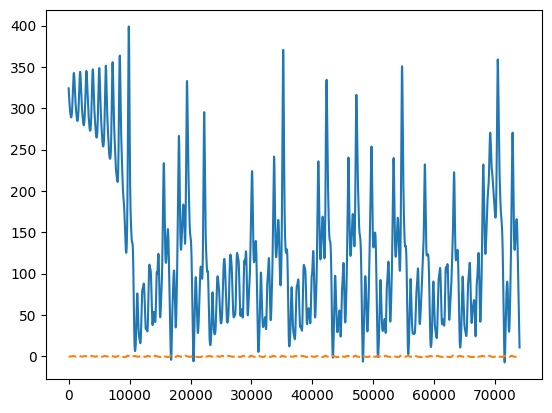

In [21]:
data = np.load("X_mmi_binary_large.npz")
X_re    = data["X_re"]
X_im    = data["X_im"]
y = data["labels"]
y_data = np.asarray(y, dtype=float)
X_data    = X_re + 1j * X_im  


def split_pos_neg(X_raw):
    xpos_list = []
    xneg_list = []
    for i in range(0, 50, 10):
        xpos_list.append(X_raw[:, i:i+5])  # pos: first 5 ports
        xneg_list.append(X_raw[:, i+5:i+10])  # neg: next 5 ports
    xpos = np.concatenate(xpos_list, axis=1)  # shape: (N, 25)
    xneg = np.concatenate(xneg_list, axis=1)  # shape: (N, 25)
    return xpos, xneg

xpos, xneg = split_pos_neg(X_data)
Y = np.abs(np.sum(xpos*weights_pos, axis =1 ))**2 - np.abs(np.sum(xneg*weights_neg, axis = 1))**2 + bias
plt.plot(Y)
plt.plot(y, linestyle = '--')
plt.show()





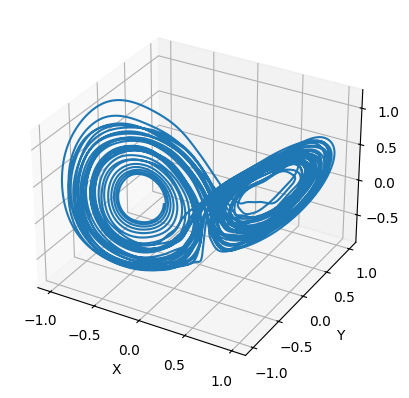

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.plot(x_norm[6080:], y_norm[6080:], z_norm[6080:])
ax.plot(x_norm[6080:80080],y_norm[6080:80080], Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [193]:
T = 10.0e-11
dt = 1e-14
t = jnp.arange(0,T,dt)
netlist = {
    "instances":{
        "pm1": "phase_modulator1",
        "pm2": "phase_modulator2",
        "pm0": "phase_modulator0",
        "wg1": "waveguide",
        "wg2": "waveguide",
        "y1": "y_branch",
        "y2": "y_branch",

},
"connections":{
    "y1,port_2":"wg1,o0",
    "y1,port_3":"wg2,o0",
    "wg1,o1": "pm1,o0",
    "wg2,o1": "pm0,o0",
    "pm1,o1": "y2,port_2",
    "pm0,o1": "y2,port_3",
    "y2,port_1": "pm2,o0",

},
"ports":{
    "o0": "y1,port_1",
    "o1": "pm2,o1",

},
}

def phase_mod(amp):
    return 2*np.arccos(amp)
phase_1 = phase_mod(np.abs(weights_pos[0]/15))
phase_2 = -phase_1/2+np.angle(weights_pos[0])
phase_mod1 = Modulator(mod_signal=phase_1*jnp.ones_like(t))
phase_mod0 = Modulator(mod_signal = 0*jnp.ones_like(t))
phase_mod2 = Modulator(mod_signal=phase_2*jnp.ones_like(t))
models = {
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
}
# wavelengths = [1.548,1.549,1.55,1.551,1.552]
# for wl in wavelengths:
models["phase_modulator1"] = phase_mod1
models["phase_modulator0"] = phase_mod0
models["phase_modulator2"] = phase_mod2
wvl = np.linspace(1.50,1.60,200)
options = {"wl":wvl, "wg1":{"length":10.0},"wg2":{"length":10.0},}
time_sim = TimeSim(netlist=netlist, models=models, settings = options)
inputs = {
    "o0": X_data[:10000,0],
    "o1": jnp.zeros_like(t),
}
c = 299792458.0
results = time_sim.run(t,inputs, carrier_freq=c/(1.548*1e-6), dt=dt)



--- Passive Sub-Netlist 0 ---

Instances: {'y1': 'y_branch', 'wg2': 'waveguide', 'wg1': 'waveguide'}

Connections: {'y1,port_2': 'wg1,o0', 'y1,port_3': 'wg2,o0'}

Ports: {'o0': 'y1,port_1', 'o1': 'wg1,o1', 'o2': 'wg2,o1'}


--- Passive Sub-Netlist 1 ---

Instances: {'y2': 'y_branch'}

Connections: {}

Ports: {'o0': 'y2,port_2', 'o1': 'y2,port_3', 'o2': 'y2,port_1'}



/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)
/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)



--- Final Time-Domain Netlist ---

Models: {'pm1': <simphony.time_domain.ideal.Modulator object at 0x76a2779f3fe0>, 'pm0': <simphony.time_domain.ideal.Modulator object at 0x76a27ac11e20>, 'pm2': <simphony.time_domain.ideal.Modulator object at 0x76a27acf2ab0>, '0': <simphony.time_domain.time_system.TimeSystemIIR object at 0x76a27aa12210>, '1': <simphony.time_domain.time_system.TimeSystemIIR object at 0x76a277aec680>}

Connections: {'0,o1': 'pm1,o0', '0,o2': 'pm0,o0', '1,o0': 'pm1,o1', '1,o1': 'pm0,o1', '1,o2': 'pm2,o0'}

Ports: {'o0': '0,o0', 'o1': 'pm2,o1'}



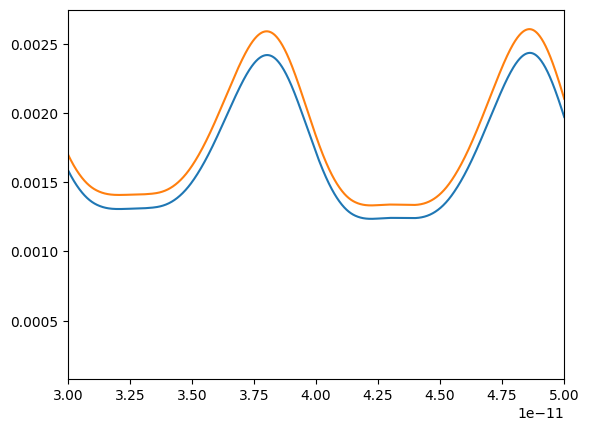

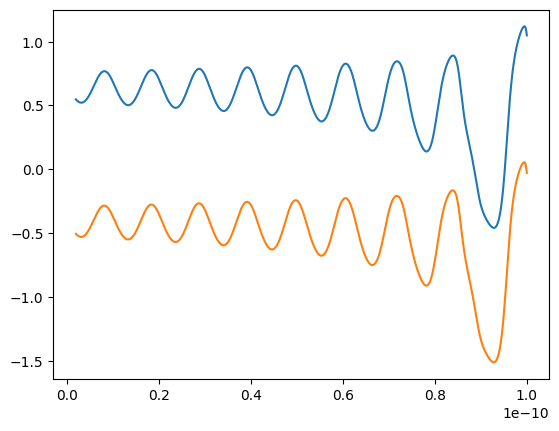

amplitude:  1.0339333265905513
phase:  -1.0559262431004295


In [194]:
output = results.outputs["o1"]
plt.plot(t[200:],np.abs(output[200:])**2)
plt.plot(t[200:],np.abs(X_data[150:9950,0]*weights_pos[0]/15)**2)
plt.xlim(0.3e-10,0.5e-10)
plt.show()
plt.plot(t[200:],np.angle(output[200:]))
plt.plot(t[200:],np.angle(X_data[150:9950,0]*weights_pos[0]/15))
plt.show()

print("amplitude: ", np.abs(X_data[3950,0]*np.abs(weights_pos[0]))/np.abs(output[4000]*15))
print("phase: ", (np.angle(X_data[3950,0]*weights_pos[0]) - np.angle(output[4000])))